# AHP-Based Candidate Ranking for Data Scientist Hiring

This notebook applies the Analytic Hierarchy Process (AHP) method to assist a Data Science squad in selecting the best candidate among six finalists.  
The decision balances multiple criteria beyond technical skills, explicitly incorporating subjective priorities agreed upon by the hiring team.

---

## Business Problem

A Data Science squad must choose the best candidate for a Data Scientist position among six finalists.  
The final decision cannot rely solely on technical test scores; other factors must be considered to find the best overall fit.

## Prioritization of Criteria

The squad agreed on the following order of importance for evaluation criteria:

1. Technical Skills (most important)  
2. Experience  
3. Soft Skills  
4. Communication  
5. Cultural Fit  

This prioritization guides the construction of the pairwise comparison matrix in AHP.

# Imports 

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# STEP 1 – Define criteria and candidates

In [3]:
criteria = [
    "Technical Skills", 
    "Soft Skills", 
    "Experience", 
    "Cultural Fit", 
    "Communication"
]
candidates = ["A", "B", "C", "D", "E", "F"]

# STEP 2 –  Simulate candidate scores per criterion (scale 1 to 10)

In [4]:
# Simulate scores for each criterion (1 to 10)
np.random.seed(42)  # For reproducibility

candidate_scores = pd.DataFrame({
    "Technical Skills":     np.random.randint(6, 10, size=6),
    "Soft Skills":          np.random.randint(5, 10, size=6),
    "Experience":           np.random.randint(4, 10, size=6),
    "Cultural Fit":         np.random.randint(5, 10, size=6),
    "Communication":        np.random.randint(4, 10, size=6)
}, index=candidates)
candidate_scores 

,Technical Skills,Soft Skills,Experience,Cultural Fit,Communication
A,8,9,8,8,5
B,9,9,7,6,9
C,6,6,6,8,8
D,8,7,9,9,7
E,8,7,8,5,4
F,9,7,5,8,4


# STEP 3 –  Construct Pairwise Comparison Matrix

## Pairwise Comparison Matrix

Below is the matrix quantifying the relative importance of criteria based on the squad’s prioritization, using Saaty’s scale.

| Criteria vs         | Tech Skills | Soft Skills | Experience | Cultural Fit | Communication |
|---------------------|-------------|-------------|------------|--------------|---------------|
| **Technical Skills** | 1           | 3           | 2          | 4            | 2             |
| **Soft Skills**      | 1/3         | 1           | 0.5        | 2            | 1             |
| **Experience**       | 0.5         | 2           | 1          | 3            | 2             |
| **Cultural Fit**     | 0.25        | 0.5         | 0.33       | 1            | 0.5           |
| **Communication**    | 0.5         | 1           | 0.5        | 2            | 1             |



In [5]:
comparison_matrix = np.array([
    [1, 3, 2, 4, 2],
    [1/3, 1, 0.5, 2, 1],
    [0.5, 2, 1, 3, 2],
    [0.25, 0.5, 0.33, 1, 0.5],
    [0.5, 1, 0.5, 2, 1]
])

comparison_df = pd.DataFrame(comparison_matrix, index=criteria, columns=criteria)
comparison_df.round(3)


,Technical Skills,Soft Skills,Experience,Cultural Fit,Communication
Technical Skills,1.000,3.0,2.00,4.0,2.0
Soft Skills,0.333,1.0,0.50,2.0,1.0
Experience,0.500,2.0,1.00,3.0,2.0
Cultural Fit,0.250,0.5,0.33,1.0,0.5
Communication,0.500,1.0,0.50,2.0,1.0


# STEP 4 –  Calculate Criteria Weights

Normalize the comparison matrix by columns and compute the average of each row to get the criteria weights.

In [6]:
column_sums = comparison_matrix.sum(axis=0)
normalized_matrix = comparison_matrix / column_sums

weights = normalized_matrix.mean(axis=1)
weights_df = pd.DataFrame({"Criteria": criteria, "Weight": weights}).set_index("Criteria")
weights_df.round(4)

,Weight
Criteria,
Technical Skills,0.3780
Soft Skills,0.1397
Experience,0.2498
Cultural Fit,0.0800
Communication,0.1526


# STEP 5 – Consistency Check
Calculate the Consistency Ratio (CR) to verify the reliability of the pairwise comparisons.

In [ ]:
#Note: Although spectral decomposition is computationally feasible for typical AHP problem sizes
#(usually fewer than 10 criteria), for very large matrices in other applications,
# the weighted sum approximation method offers a computationally cheaper alternative to estimate
#the principal eigenvalue and assess consistency.

# weighted_sum = comparison_matrix @ weights
# consistency_vector = weighted_sum / weights
# lambda_max_1 = consistency_vector.mean()
# n = comparison_matrix.shape[0]#
# CI = (lambda_max - n) / (n - 1)

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(comparison_matrix)
#Find the largest real eigenvalue
lambda_max = max(eigenvalues.real)
# Get the principal eigenvector (corresponding to the largest eigenvalue) and normalize it to sum to 1
max_index = np.argmax(eigenvalues.real)
principal_eigenvector = eigenvectors[:, max_index].real
weights = principal_eigenvector / principal_eigenvector.sum()

# 4. Calculate the Consistency Index (CI)
n = comparison_matrix.shape[0]
CI = (lambda_max - n) / (n - 1)


RI_dict = {1: 0, 2: 0, 3: 0.58, 4: 0.9, 5: 1.12,
           6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}

CR = CI / RI_dict[n]

print(f"λ_max = {lambda_max:.4f}")
print(f"Consistency Index (CI) = {CI:.4f}")
print(f"Consistency Ratio (CR) = {CR:.4f}")

if CR < 0.1:
    print("Consistency Ratio is acceptable.")
else:
    print("Consistency Ratio is NOT acceptable. Reconsider the pairwise comparisons.")


λ_max = 5.0471
Consistency Index (CI) = 0.0118
Consistency Ratio (CR) = 0.0105
Consistency Ratio is acceptable.


# STEP 6 – Final Candidate Scores and Ranking

Multiply candidate scores by criteria weights and compute the final score for each candidate.

In [13]:
final_scores = candidate_scores.values @ weights
ranking = pd.DataFrame({
    "Candidate": candidates,
    "Final Score": final_scores
}).sort_values(by="Final Score", ascending=False).reset_index(drop=True)

ranking

,Candidate,Final Score
0,B,8.261533
1,D,8.038829
2,A,7.684358
3,E,7.015636
4,F,6.885999
5,C,6.462550


# STEP 7 – Conclusion

The AHP method allowed the squad to incorporate both subjective priorities and candidate performance into a rigorous multi-criteria decision-making process.

Based on the analysis, **Candidate B** demonstrated the highest overall alignment with the squad’s priorities and is the recommended choice for the Data Scientist position.

---

## Candidate Scores Recap

Below is a table with the detailed scores of all candidates across all evaluation criteria for reference.


In [14]:
# Show candidate scores again for clarity
display(candidate_scores)
# Show final ranking again
display(ranking)

,Technical Skills,Soft Skills,Experience,Cultural Fit,Communication
A,8,9,8,8,5
B,9,9,7,6,9
C,6,6,6,8,8
D,8,7,9,9,7
E,8,7,8,5,4
F,9,7,5,8,4


,Candidate,Final Score
0,B,8.261533
1,D,8.038829
2,A,7.684358
3,E,7.015636
4,F,6.885999
5,C,6.462550


# STEP 8 – Sensitivity Analysis

Sensitivity Analysis tests how sensitive the final candidate ranking is to changes in the weights assigned to the evaluation criteria.

Since the criteria weights are derived from subjective pairwise comparisons, small variations might affect the final decision. Understanding this helps validate the robustness and reliability of the selection.

---

### Approach

We vary the weight of a key criterion — in this case, **Technical Skills** — within a reasonable range (±15%) to simulate uncertainty or subjectivity in the decision-making process.

For each adjusted weight, we recalculate the final weighted scores of the candidates and observe how their rankings change.

This helps answer questions such as:  
- If the importance of Technical Skills increases or decreases, does Candidate B remain the top choice?  
- Which candidates’ rankings are most affected by weight changes?

---

**Objective:**  
To determine whether the recommended candidate remains the top choice even when criterion weights vary, thereby confirming the stability and reliability of the decision.

If the rankings remain stable despite these perturbations, we gain confidence that the decision is robust and not overly sensitive to exact weight values.


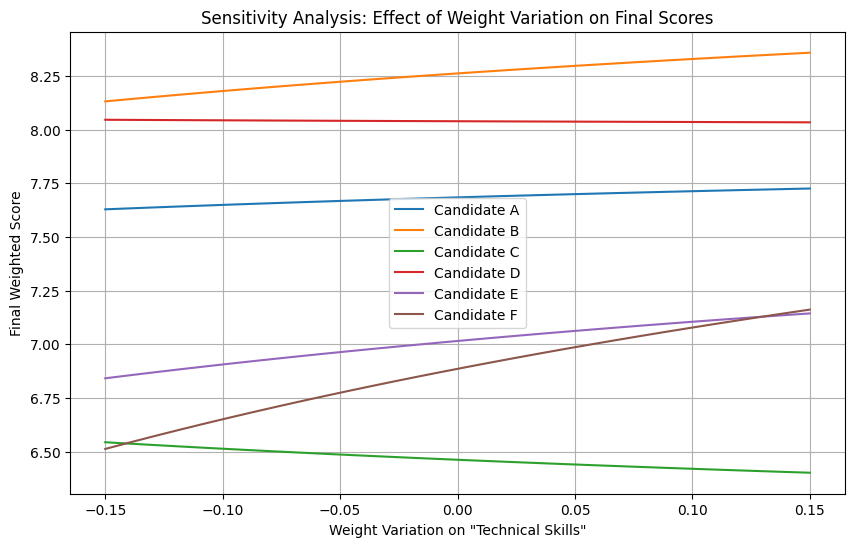

In [16]:
def sensitivity_analysis(base_weights, candidate_scores, criterion_index, variation_range):
    candidates = candidate_scores.index.tolist()
    rankings_over_variation = []

    for delta in variation_range:
        modified_weights = base_weights.copy()
        modified_weights[criterion_index] = base_weights[criterion_index] + delta
        # Normalize weights to sum to 1
        modified_weights = modified_weights / modified_weights.sum()
        
        final_scores = candidate_scores.values @ modified_weights
        rankings_over_variation.append(final_scores)

    rankings_over_variation = np.array(rankings_over_variation)

    plt.figure(figsize=(10,6))
    for i, candidate in enumerate(candidates):
        plt.plot(variation_range, rankings_over_variation[:, i], label=f'Candidate {candidate}')
    plt.xlabel(f'Weight Variation on "{criteria[criterion_index]}"')
    plt.ylabel('Final Weighted Score')
    plt.title('Sensitivity Analysis: Effect of Weight Variation on Final Scores')
    plt.legend()
    plt.grid(True)
    plt.show()

variation_range = np.linspace(-0.15, 0.15, 30)
sensitivity_analysis(weights, candidate_scores, criterion_index=0, variation_range=variation_range)

## Conclusion

From the graph, we can visually confirm that the final ranking is preserved even with small variations in the weight of the most important criterion, **Technical Skills**.

This indicates that the decision is robust and not overly sensitive to minor changes in the subjective weighting, increasing confidence in the recommended candidate.
